In [1]:
import numpy as np
import scipy as sp
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import trange, tqdm
import numpy.linalg as LA
from utils import *
plt.rcParams['figure.dpi'] = 150 # default for me was 75
%matplotlib notebook

# SINDy for PDEs

We first start by simulating the desired PDE. In this case, we will consider Burger's Equation:
$$
u_t = 2 u_x -2uu_x+.001u_{xx}
$$
for $0<x<10$ with initial condition $u(0,x) = \text{sech}(x-5)$ and periodic boundary conditions.

In [2]:
### Burgers
NPoints = 2**11      # Spacial Resolution
t_stop = 1        # Stoping Time
dt = .0002           # Time step size
sampling_rate = 1   # How often do you save?
Lx = 10               # Space Size

# Input Coefficients [1, u, u_x, u_xx, u^2, u*u_x, u*u_xx, u_x^2, u_x*u_xx, u_xx^2]
c = [0,0, 2,.001,0,-2, 0 ,0,0,0]

We then set up the split-step method. We calculate the linear and nonlinear steps. We also input the initial condition and calculate the first step of the method.

In [3]:
### Matrices 
dx = Lx/NPoints                             # Space step size 
t = np.arange(0, NPoints)                   # time space      
kx = np.fft.fftfreq(NPoints, 1/NPoints)     # Frequency for fourier transform
kx = 2*np.pi/Lx*kx                          # Adjusting by length of interval
L = c[1] + c[2]*1j*kx - c[3]*kx**2          # Calculate Linear piece exactly        
NL = np.empty(NPoints, dtype = complex)     # Allocate Space for Nonlinear

for j in range(NPoints):                    # Calculate Nonlinear piece
    if abs(L[j])<0.000001:
        NL[j] = dt 
    else:
        NL[j] = (np.exp(L[j]*dt)-1)/L[j]

### Initial Condition
x = t/NPoints*Lx
U = 1/np.cosh(x-5) 

Ul = np.fft.fft(U)

U_x = np.fft.ifft(1j*kx*np.fft.fft(U))
U_xx = np.fft.ifft(-kx**2*np.fft.fft(U))


Unl = np.fft.fft(np.dot(c[4:], [U**2, U*U_x, U*U_xx, U_x**2, U_x*U_xx, U_xx**2]))

We then run the split step method. We save at the sampling rate (kmax). We plot the initial condition and final position.

<IPython.core.display.Javascript object>


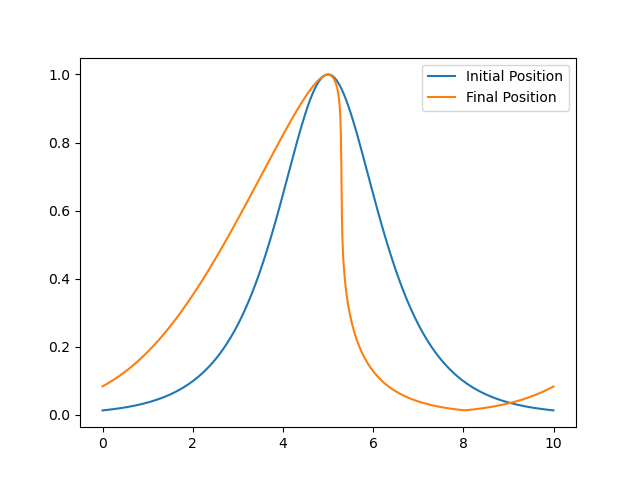

<IPython.core.display.Javascript object>


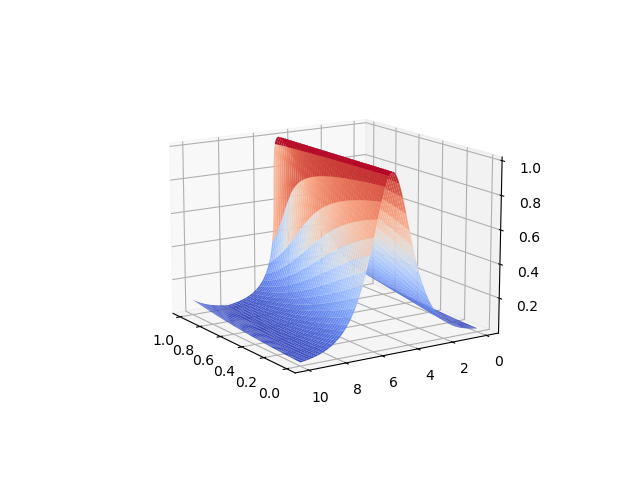

In [4]:
imax = int(t_stop/(dt*sampling_rate)) #int(t_stop/dt*sampling_rate) 
kmax = sampling_rate #int(t_stop/dt/sampling_rate)


U_save = np.empty([NPoints,imax], dtype = complex)
U_save[:,0] = U


### Time Evolution

for i in trange(imax-1, desc = 'Simulation', position = 0):
    for k in range(kmax):
        U = np.multiply(np.exp(L*dt),Ul)+np.multiply(NL, Unl)
        Ul = np.fft.ifft(U)
        if k == kmax-1:
            U_save[:,i+1] = Ul
        U_x = np.fft.ifft(1j*kx*U)
        U_xx = np.fft.ifft(-kx**2*U)
        Unl = np.fft.fft(np.dot(c[4:], [Ul**2, Ul*U_x, Ul*U_xx, U_x**2, U_x*U_xx, U_xx**2]))
        Ul = U
        if np.isnan(Ul[0]) == True:
            sys.exit()

fig = plt.figure()
ax = plt.axes()
ax.plot(x,abs(U_save[:,0]), label = 'Initial Position')
U_save[:,-1] = np.fft.ifft(U)   
ax.plot(x,abs(U_save[:,-1]), label = 'Final Position')      
ax.legend() 

fig3d = plt.figure()
ax3d = plt.axes(projection = '3d')
T,X = np.meshgrid(np.arange(0,t_stop,dt), x)
ax3d.plot_surface(T,X,abs(U_save), cmap = cm.coolwarm, linewidth = 0)

We now calculate the correlation time from the simulation:

In [5]:
def time_cor(X, dt):
      n = X.shape[0]
      cor = np.empty(int(n/2))
      mean = np.mean(X, axis = 0) # Allocate space for correlation (run for t<n/2)
      var = np.sqrt(np.var(X, axis = 0))
      for k in range(int(n/2)):
          cor[k] = 0
          for i in range(int(n/2)):
              cor[k] += np.dot((X[i,:]-mean)/var,(X[i+k,:]-mean)/var)/(int(n/2))
          if np.sign(cor[k]) == -1:
              break
      point = k
      value = dt*point 
      return point, value
 
    
point, value = time_cor(abs(U_save.T), dt)   
print(value)
   

0.3224


## Running SINDy

In this instance, we do not modify the input data. However, that can be done here by modifying U_test with respect to U_save. Sparsity or noise can be added to test SINDy's ability to discover the underlying system. We then calculate our time and spatial derivatives.

In [6]:
U_test = np.real(U_save.T)

# Estimate Time Derivatives
U_t = np.empty(U_test.shape, dtype = complex)
D = D_Lele(U_test.shape[0],t_stop/U_test.shape[0]) 

for i in trange(U_test.shape[1], desc = 'U_t', position = 0):
    U_t[:,i] = np.dot(D.toarray(), U_test[:,i])

# Estimate Spatial Derivatives
U_x = np.fft.ifft(1j*kx*np.fft.fft(U_test, axis = 1))    
U_xx = np.fft.ifft(-kx**2*np.fft.fft(U_test, axis = 1))   

We transform the matrices into vectors and construct our library as $\{u,u_x,u_{xx}\}$. We then generate the $\Theta$ matrix with polynomial combinations of the library elements up to degree 2.

In [7]:
U_new = U_test.flatten(order = 'F')
U_t_new = U_t.flatten(order = 'F')
U_x_new = U_x.flatten(order = 'F')
U_xx_new = U_xx.flatten(order = 'F')

print('Spacial Derivatives Done')

Library = np.column_stack([U_new,U_x_new,U_xx_new])

total_variable = 3
total_guesses = 1+total_variable+6
Theta = np.empty([(U_test.shape[0])*U_test.shape[1], total_guesses], dtype = complex)

i = 0
Theta[:,i] = np.ones([(U_test.shape[0])*U_test.shape[1]])
i = i+1

for j in range(total_variable):
    Theta[:,i] = Library[:, j]
    i = i+1

# Uncomment if quadratic terms are desired 
for j in range(total_variable):
    for l in range(total_variable-j):
        Theta[:,i] = Library[:,j]*Library[:,l+j]
        i = i+1


Spacial Derivatives Done


Finally, we run SINDy on the resulting $\Theta$ matrix with $u_t$ as calculated above.

In [12]:
Xi_sindy = LA.lstsq(Theta,U_t_new, rcond = None)[0]

l=0.0005

for k in range(10):
    condition = np.abs(Xi_sindy) > l
    Xi_sindy = np.where(condition, Xi_sindy, np.zeros(Xi_sindy.shape))

    for j in range(1):
        vec = condition[:,]
        bigind = [i for i in range(len(vec)) if vec[i] == True]
        Xi_sindy[bigind] = LA.lstsq(Theta[:, bigind], U_t_new, rcond = None)[0]
Print = ['1','u','u_x','u_xx','u^2', 'uu_x','uu_xx', 'u_x^2', 'u_xu_xx','u_xx^2']
Print_1 = []
print('Rounded Results')
for i in range(total_guesses):
    Print_1.append([Print[i], np.round(Xi_sindy[i],3)])
    print(Print_1[i])
    
print('')
print('Full Results')
Print_1 = []
for i in range(total_guesses):
    Print_1.append([Print[i], Xi_sindy[i]])
    print(Print_1[i])

Rounded Results
['1', 0j]
['u', 0j]
['u_x', (2-0j)]
['u_xx', (0.001-0j)]
['u^2', 0j]
['uu_x', (-2+0j)]
['uu_xx', 0j]
['u_x^2', 0j]
['u_xu_xx', 0j]
['u_xx^2', 0j]

Full Results
['1', 0j]
['u', 0j]
['u_x', (1.9999662129467757-1.45125722181308e-10j)]
['u_xx', (0.0010879832348520413-1.1930143700262533e-11j)]
['u^2', 0j]
['uu_x', (-1.9997889699228433+2.3643928482602415e-10j)]
['uu_xx', 0j]
['u_x^2', 0j]
['u_xu_xx', 0j]
['u_xx^2', 0j]


We can now use the discovered coefficients to simulate the with the same intitial condition.

In [13]:
c_new = Xi_sindy

### Matrices 
dx = Lx/NPoints                             # Space step size 
t = np.arange(0, NPoints)                   # time space      
kx = np.fft.fftfreq(NPoints, 1/NPoints)     # Frequency for fourier transform
kx = 2*np.pi/Lx*kx                          # Adjusting by length of interval
L = c_new[1] + c_new[2]*1j*kx - c_new[3]*kx**2          # Calculate Linear piece exactly        
NL = np.empty(NPoints, dtype = complex)     # Allocate Space for Nonlinear

for j in range(NPoints):                    # Calculate Nonlinear piece
    if abs(L[j])<0.000000001:
        NL[j] = dt 
    else:
        NL[j] = (np.exp(L[j]*dt)-1)/L[j]

### Initial Condition
x = t/NPoints*Lx
U = 1/np.cosh(x-5) 

Ul = np.fft.fft(U)

U_x = np.fft.ifft(1j*kx*np.fft.fft(U))
U_xx = np.fft.ifft(-kx**2*np.fft.fft(U))


Unl = np.fft.fft(np.dot(c_new[4:], [U**2, U*U_x, U*U_xx, U_x**2, U_x*U_xx, U_xx**2]))


imax_new = int(imax/2) #int(t_stop/dt*sampling_rate) 
kmax = sampling_rate #int(t_stop/dt/sampling_rate)


U_save_sim = np.empty([NPoints,imax_new], dtype = complex)
U_save_sim[:,0] = U


### Time Evolution

for i in trange(imax_new, desc = 'Simulation 2', position = 0):
    for k in range(kmax):
        U = np.multiply(np.exp(L*dt),Ul)+np.multiply(NL, Unl)
        Ul = np.fft.ifft(U)
        if k == kmax-1:
            U_save_sim[:,i] = Ul
        U_x = np.fft.ifft(1j*kx*U)
        U_xx = np.fft.ifft(-kx**2*U)
        Unl = np.fft.fft(np.dot(c_new[4:], [Ul**2, Ul*U_x, Ul*U_xx, U_x**2, U_x*U_xx, U_xx**2]))
        Ul = U
        if np.isnan(Ul[0]) == True:
            sys.exit()


We can plot the resulting error of the system at the final point:

<IPython.core.display.Javascript object>


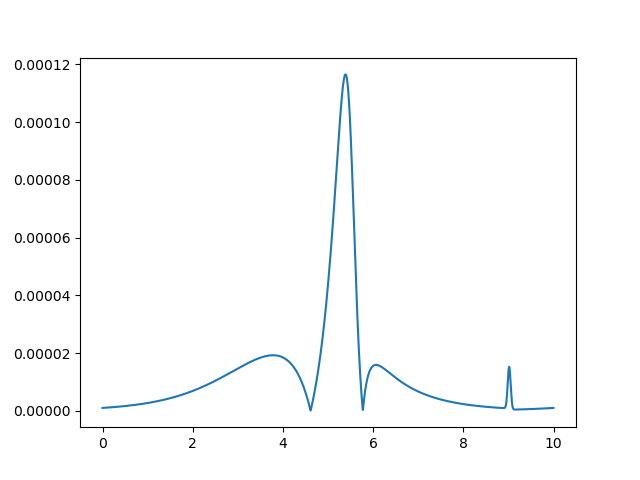

<IPython.core.display.Javascript object>


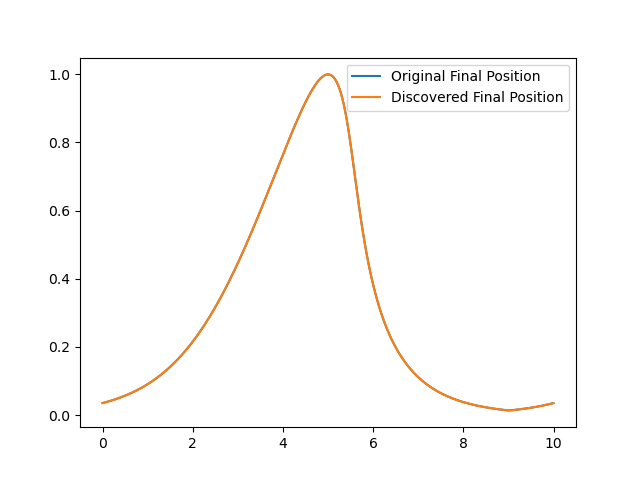

<IPython.core.display.Javascript object>


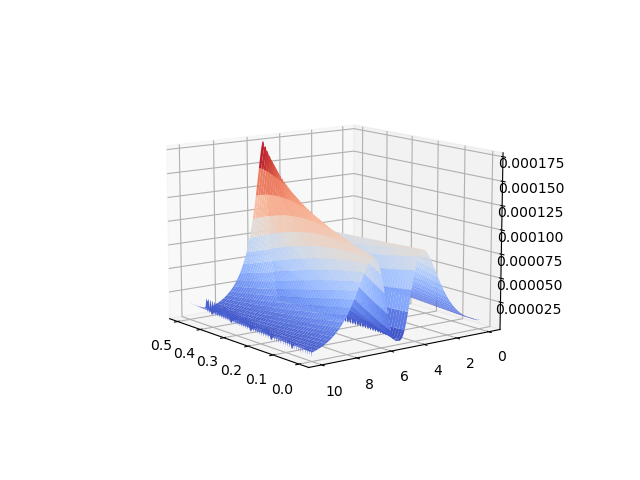

In [14]:
fig = plt.figure()
ax = plt.axes()
ax.plot(x,abs(U_save[:,imax_new]-U_save_sim[:,-1]))

fig = plt.figure()
ax = plt.axes()
ax.plot(x,abs(U_save[:,imax_new]),label = 'Original Final Position')
ax.plot(x,abs(U_save_sim[:,-1]), label = 'Discovered Final Position')
ax.legend()

fig3d = plt.figure()
ax3d = plt.axes(projection = '3d')
T,X = np.meshgrid(np.arange(0,t_stop/2,dt), x)
ax3d.plot_surface(T,X,abs(U_save_sim-U_save[:,:imax_new]), cmap = cm.coolwarm, linewidth = 0)